# [Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks<br />通过多种无参数攻击的集成来可靠地评估对抗鲁棒性](http://arxiv.org/abs/2003.01690)

We propose a new gradient-based scheme, Auto-PGD, which does not require a step size to be chosen and an alternative loss function.  
我们提出了一种新的基于梯度的方案——Auto-PGD，它不需要选择步长和其他损失函数。

We combine our two new versions of PGD with FAB and Square Attack to form a parameter-free, computationally affordable and userindependent ensemble of complementary attacks to estimate adversarial robustness, named *AutoAttack*.  我们将两个新版本的 PGD 与 FAB 和 Square Attack 结合起来，形成了一个无参数、计算成本低廉、与用户无关的互补攻击组合，用于估算对抗鲁棒性，命名为*AutoAttack*。

## Auto-PGD: A budget-aware step size-free variant of PGD<be />Auto-PGD：预算感知的无步长 PGD 变体

We identify three weaknesses in the standard formulation of the PGD-attack and how it is used in the context of adversarial robustness.  
我们指出了 PGD 攻击标准表述中的三个弱点，以及如何将其用于对抗鲁棒性。

1. the **fixed step size** is suboptimal, as even for convex problems this does not guarantee convergence, and the performance of the algorithm is highly influenced by the choice of its value.  
**固定步长**是次优的，因为即使对于凸问题，这也不能保证收敛，而且算法的性能受步长值选择的影响很大。

2. the overall scheme is in general **agnostic of the budget** given to the attack: as we show, the loss plateaus after a few iterations, except for extremely small step sizes, which however do not translate into better results. As a consequence, judging the strength of an attack by the number of iterations is misleading.  
总体方案一般**与攻击预算无关**：正如我们所展示的，除了极小的步长之外，迭代几次后损失就会趋于平稳，但这并不会带来更好的结果。因此，通过迭代次数来判断攻击强度是有误导性的。

3. the algorithm is **unaware of the trend**, i.e. does not consider whether the optimization is evolving successfully and is not able to react to this.  
算法**不了解趋势**，即不考虑优化是否成功，也无法对此做出反应。


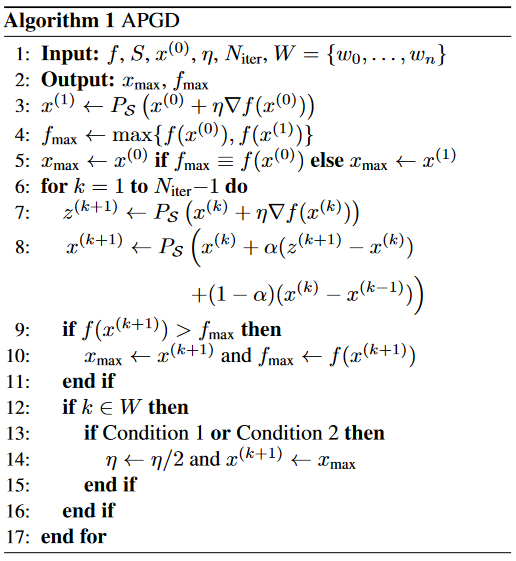

$α ∈ [0, 1]$ (we use $α = 0.75$) regulates the influence of the previous update on the current one.  
$α∈ [0, 1]$（我们使用 $α = 0.75$）调节前一次更新对当前更新的影响。

$η^{(0)} = 2\epsilon$,$w_{0}=0$

$f^{(k)}_{max}$ is the highest objective value found in the first $k$ iterations.  
$f^{(k)}_{max}$ 是前 $k$ 次迭代中发现的最高目标值。

*Condition 1*:$ \sum^{w_{j}-1}_{i=w_{j-1}} \bf{1}_{f(x^{(i+1)})>f(x^{(i)})} < \rho · (w_{j}-w_{j-1}) $ 

*Condition 2*:$ η^{(w_{j−1})} ≡ η^{(w_{j})} \ \rm{and} \ f^{(w_{j−1})}_{max} ≡ f^{(w_{j})}_{max}$

$ρ = 0.75$

$w_{j} = \lceil p_{j}N_{iter} \rceil ≤ N_{iter}$, $p_{j} ∈ [0, 1]$, $p_{0} = 0$, $p_{1} = 0.22$ ,$p_{j+1} = p_{j} + \max \{ p_{j} − p_{j}−1 − 0.03, 0.06 \} $

The only free variable is the budget $N_{iter}$  
唯一的自由变量是预算 $N_{iter}$

## An alternative loss<br />一种可替换的损失

If $x$ has correct class $y$, the cross-entropy loss at $x$ is  
如果 $x$ 的正确类别为 $y$，则 $x$ 的交叉熵损失为

$$
CE(x,y)=-z_{y}+\rm{log} (\sum_{j=1}^{K} e^{z_{j}})
$$

The CW loss defined as  
CW损失定义为

$$
CW(x,y)=-z_{y}+ \max_{i \not= y} z_{i}
$$

Difference of Logits Ratio (DLR) loss:  
DLR损失：

$$
DLR(x,y)=-\frac{z_{y}- \max_{i \not= y} z_{i}}{z_{\pi_{1}}-z_{\pi_{3}}}
$$

π is the ordering of the components of z in decreasing order.

Furthermore, we adapt our DLR loss to induce misclassification into a target class t by

$$
\rm{Targeted-DLR(x,y)=-\frac{z_{y}-z_{t}}{z_{\pi_{1}}-(z_{\pi_{3}}+z_{\pi_{4}})/2}}
$$


In total these experiments show: 

- APGD outperforms PGD/PGD with Momentum consistently regardless of the employed loss.
- Our DLR loss improves upon the CE loss and is comparable to the CW loss, but with less severe failure cases.

## AutoAttack

$$
\rm{AutoAttack} = \rm{APGD}_{CE} + \rm{APGD}_{CE} + \rm{FAB} + \rm{SquareAttack}
$$

In [9]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
CIFAR10_train = dset.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
CIFAR10_test = dset.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(CIFAR10_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
model = torchvision.models.wide_resnet50_2(weights=torchvision.models.Wide_ResNet50_2_Weights.DEFAULT).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)

In [13]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        X=images.to(device)
        Y=labels.to(device)
        
        logits = model(X)
        cost = loss(logits, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 128 == 0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_loader),cost.item()))

print("Finished Training")

epoch:[1/10], iter:[128/391], loss:1.57628
epoch:[1/10], iter:[256/391], loss:1.34754
epoch:[1/10], iter:[384/391], loss:1.10063
epoch:[2/10], iter:[128/391], loss:0.90591
epoch:[2/10], iter:[256/391], loss:0.87596
epoch:[2/10], iter:[384/391], loss:0.79944
epoch:[3/10], iter:[128/391], loss:0.60852
epoch:[3/10], iter:[256/391], loss:0.70106
epoch:[3/10], iter:[384/391], loss:0.54989
epoch:[4/10], iter:[128/391], loss:0.46031
epoch:[4/10], iter:[256/391], loss:0.51870
epoch:[4/10], iter:[384/391], loss:0.45563
epoch:[5/10], iter:[128/391], loss:0.24562
epoch:[5/10], iter:[256/391], loss:0.27109
epoch:[5/10], iter:[384/391], loss:0.17406
epoch:[6/10], iter:[128/391], loss:0.22447
epoch:[6/10], iter:[256/391], loss:0.28859
epoch:[6/10], iter:[384/391], loss:0.31070
epoch:[7/10], iter:[128/391], loss:0.20079
epoch:[7/10], iter:[256/391], loss:0.10185
epoch:[7/10], iter:[384/391], loss:0.16156
epoch:[8/10], iter:[128/391], loss:0.07930
epoch:[8/10], iter:[256/391], loss:0.07125
epoch:[8/10

In [14]:
model.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    _, predicted = torch.max(logits.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 81.459999 %


In [15]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='standard')

setting parameters for standard version


In [16]:
total = 0
correct = 0

for images, labels in test_loader:

    images, labels = images.to(device), labels.to(device)
    
    x_adv = adversary.run_standard_evaluation(images, labels, bs=128)
    x_adv = x_adv.to(device)

    outputs = model(x_adv)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the adversarial images: %f %%' % (100 * correct / total))


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 83.59%
apgd-ce - 1/1 - 107 out of 107 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 6.6 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 80.47%
apgd-ce - 1/1 - 103 out of 103 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 6.5 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 88.28%
apgd-ce - 1/1 - 112 out of 113 successfully perturbed
robust accuracy after APGD-CE: 0.78% (total time 6.4 s)
apgd-t - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-T: 0.00% (total time 15.8 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0